In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:12 http://ppa.launchpad.net/cran/libgit2/u

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-04-10 00:28:10--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  5.73MB/s    in 0.2s    

2022-04-10 00:28:11 (5.73 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("M16-Amazon-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
#Load Amazon data into a Spark dataframe
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   10293599|R14LVB34Z2Z53I|B000YMOQZY|     262935067|Knockin' On Heave...|Digital_Music_Pur...|          5|            0|          0|   N|                Y|           favorites|Great  rendition....| 2015-08-31|
|         US|    6087195|R2M0R9CWPC82LT|B00ISAEC80|     452318038|            Flawless|Digital_Music_Pur

In [5]:
# Create the vine_table. DataFrame
vine_df = df.select(["review_id", "star_rating", "helpful_votes", "total_votes", "vine", "verified_purchase"])
vine_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R14LVB34Z2Z53I|          5|            0|          0|   N|                Y|
|R2M0R9CWPC82LT|          5|            0|          0|   N|                Y|
| RQNQI2R3BM52A|          4|            0|          0|   N|                Y|
| RTUIX1135HUAB|          5|            0|          0|   N|                Y|
| RE3QSAT8TL010|          4|            0|          0|   N|                Y|
|R14TN65IY0NUOD|          5|            0|          0|   N|                Y|
|R3LIF8MCNH1ODF|          5|            0|          0|   N|                Y|
|R33X0DGA4PPQ3L|          5|            3|          3|   N|                N|
|R2DJJP7DQRT1ZW|          5|            0|          1|   N|                Y|
|R2A8XDXW5XOT4H|          5|            0|          0|   N|     

In [6]:
#filter the dataFrame for rows with total_votes >= 20
popular_votes_df = vine_df.filter("total_votes>=20")
popular_votes_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1S0N56H5B9SUX|          5|           30|         30|   N|                Y|
| RCDI7Z8VCZJI9|          4|           40|         43|   N|                N|
|R3F4225VTUO2WE|          1|            8|         33|   N|                N|
|  R3ADPNURCCTK|          1|            1|         39|   N|                N|
|R2LWBYC8TEUVF2|          5|           50|         53|   N|                Y|
|R23E4EIJXID5IC|          5|           43|         43|   N|                N|
|R1WFSWDT8L5RSJ|          4|           23|         26|   N|                N|
|R37LMHN02KOER1|          5|           50|         50|   N|                N|
|R297QI4VU3LMY6|          4|           41|         50|   N|                N|
| RGNU1L1XFX33B|          3|           34|         35|   N|     

In [7]:
#further filter the data frame to show rows where helpful_votes divided by total_votes is >= to 50%
helpful_votes_df = popular_votes_df.filter("helpful_votes / total_votes * 100 >= 50")
helpful_votes_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1S0N56H5B9SUX|          5|           30|         30|   N|                Y|
| RCDI7Z8VCZJI9|          4|           40|         43|   N|                N|
|R2LWBYC8TEUVF2|          5|           50|         53|   N|                Y|
|R23E4EIJXID5IC|          5|           43|         43|   N|                N|
|R1WFSWDT8L5RSJ|          4|           23|         26|   N|                N|
|R37LMHN02KOER1|          5|           50|         50|   N|                N|
|R297QI4VU3LMY6|          4|           41|         50|   N|                N|
| RGNU1L1XFX33B|          3|           34|         35|   N|                N|
|R2NPE00F48X0ET|          5|           22|         27|   N|                N|
| RSPQFPJ4ISKS3|          5|           32|         35|   N|     

In [8]:
#Create dataframe for reviews that were created as part of the Vine program
vine_helpful_df = helpful_votes_df.filter("vine=='Y'")
vine_helpful_df.show()

+---------+-----------+-------------+-----------+----+-----------------+
|review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+---------+-----------+-------------+-----------+----+-----------------+
+---------+-----------+-------------+-----------+----+-----------------+



In [9]:
#Create a dataframe for reviews that were not created through Vine
nonvine_helpful_df = helpful_votes_df.filter("vine=='N'")
nonvine_helpful_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1S0N56H5B9SUX|          5|           30|         30|   N|                Y|
| RCDI7Z8VCZJI9|          4|           40|         43|   N|                N|
|R2LWBYC8TEUVF2|          5|           50|         53|   N|                Y|
|R23E4EIJXID5IC|          5|           43|         43|   N|                N|
|R1WFSWDT8L5RSJ|          4|           23|         26|   N|                N|
|R37LMHN02KOER1|          5|           50|         50|   N|                N|
|R297QI4VU3LMY6|          4|           41|         50|   N|                N|
| RGNU1L1XFX33B|          3|           34|         35|   N|                N|
|R2NPE00F48X0ET|          5|           22|         27|   N|                N|
| RSPQFPJ4ISKS3|          5|           32|         35|   N|     

In [10]:
#get a count of non vine created reviews from the filtered data set
total_reviews = nonvine_helpful_df.select("star_rating").count()
total_reviews


4532

In [11]:
#get a count of non vine reviews that had five stars
five_stars = nonvine_helpful_df.filter("star_rating == 5").count()
five_stars

2507

In [12]:
#convert total, count and percentage into a pandas dataFrame. Round Percentage to two decimal places
import pandas as pd
import numpy as np
data = {"Total Reviews": [total_reviews], "Five Star Reviews":  [five_stars], "Percentage": [five_stars/total_reviews * 100]}
no_vine_pandas_df = pd.DataFrame(data)
no_vine_pandas_df["Percentage"] = np.round(no_vine_pandas_df["Percentage"], decimals = 2)
no_vine_pandas_df.set_axis(["Reviews not through Vine"], inplace=True)
no_vine_pandas_df.head()

,Total Reviews,Five Star Reviews,Percentage
Reviews not through Vine,4532,2507,55.32


In [14]:
#get a count of other star reviews
four_stars = nonvine_helpful_df.filter("star_rating == 4").count()
four_stars


614

In [15]:
three_stars = nonvine_helpful_df.filter("star_rating == 3").count()
three_stars

325

In [17]:
two_stars = nonvine_helpful_df.filter("star_rating == 2").count()
two_stars

270

In [18]:
one_star = nonvine_helpful_df.filter("star_rating == 1").count()
one_star

816

In [30]:
star_data = [["Five Stars",five_stars], ["Four Stars", four_stars], ["Three Stars", three_stars], ["Two Stars",two_stars], ["One Stars",one_star]]
star_df = pd.DataFrame(star_data)
star_df.columns = ["Review", "Count"]
star_df.head()

,Review,Count
0,Five Stars,2507
1,Four Stars,614
2,Three Stars,325
3,Two Stars,270
4,One Stars,816


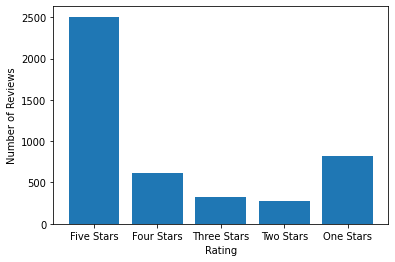

In [43]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.bar(star_df["Review"],star_df["Count"])
plt.ylabel("Number of Reviews")
plt.xlabel("Rating")
plt.show()
